In [30]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.signal import butter, filtfilt

In [5]:
def get_cfg_files(base_path):
    cfg_dict = {}

    # Traverse the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            cfg_files = []
            pat_info_path = None

            # Traverse files in the folder
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".cfg"):
                    file_path = os.path.join(folder_path, file_name)
                    if file_name == "PatInfo.cfg":
                        pat_info_path = file_path
                    else:
                        cfg_files.append(file_path)

            # Add to dictionary if any .cfg files are found
            if pat_info_path or cfg_files:
                cfg_dict[folder_name] = {"patient_info": pat_info_path, "patient_data": cfg_files}

    return cfg_dict

test_dict = get_cfg_files("NewSavedData")
print(test_dict["FC_Astana_4"])

{'patient_info': 'NewSavedData\\FC_Astana_4\\PatInfo.cfg', 'patient_data': ['NewSavedData\\FC_Astana_4\\2025-07-03T14_14_10.cfg', 'NewSavedData\\FC_Astana_4\\2025-07-03T14_22_39.cfg', 'NewSavedData\\FC_Astana_4\\2025-07-03T14_28_03.cfg']}


In [6]:
def process_cfg_file(cfg_path):
    """Process a CFG file and extract the GlobalArray data"""
    try:
        with open(cfg_path, 'r', encoding='utf-8') as f:
            cfg_content = f.read()
    except Exception as e:
        print(f"Error reading file {cfg_path}: {e}")
        return None

    # Extract the GlobalArray data

    # Split the string into Info and GlobalArray parts
    info_part = cfg_content.split("Info=")[1].split("GlobalArray=")[0].strip()
    global_array_part = "[" + cfg_content.split("GlobalArray=[")[1]

    # Convert to Python dictionaries
    info = json.loads(info_part)
    global_array = json.loads(global_array_part)

    # Now you have two Python dictionaries
    if global_array is None:
        print("Failed to extract GlobalArray data")
        return None

    return info, global_array

def lowpass_filter(data, cutoff=5, fs=100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def get_segments(times, data, plateau_groups, min_length=10):
    segments = []

    for i, group in enumerate(plateau_groups):
        if len(group) >= min_length:
            start_idx, end_idx = group[0], group[-1] + 1  # +1 because we used diff earlier
            segment_times = times[start_idx:end_idx+1]

            # Check for large gaps within the segment
            split_points = []
            for j in range(1, len(segment_times)):
                if segment_times[j] - segment_times[j-1] > 10000:  # Gap > 10000 ms
                    split_points.append(j)

            if not split_points:
                # No large gaps, keep the whole segment
                segments.append((segment_times[0], segment_times[-1]))
            else:
                # Split the segment at gap points
                prev_split = 0
                for split in split_points:
                    if split - prev_split >= min_length:
                        segments.append((segment_times[prev_split], segment_times[split-1]))
                    prev_split = split

                # Add the remaining part after last split if long enough
                if len(segment_times) - prev_split >= min_length:
                    segments.append((segment_times[prev_split], segment_times[-1]))

    return segments

def plot_segments(times, data, segments, sensor_name="Test"):
    plt.figure(figsize=(12, 6))
    # Convert times to a numpy array for efficient comparison
    times_np = np.array(times)
    plt.plot(times_np, data, 'b-', linewidth=1, label='Filtered Data')

    for i, (start_time, end_time) in enumerate(segments):
        # Find the indices corresponding to the segment times using the numpy array
        start_idx = np.where(times_np >= start_time)[0][0]
        end_idx = np.where(times_np <= end_time)[0][-1]

        plt.plot(times_np[start_idx:end_idx+1], data[start_idx:end_idx+1],
                'r-', linewidth=2, label='Plateau' if i == 0 else None)

    plt.title(f'{sensor_name}: Data with Plateau Regions')
    plt.xlabel('Relative Time (ms)')
    plt.ylabel('Angle (degrees)')
    plt.grid(True)
    plt.legend()
    plt.show()

def refine_segments(segments):
    """
    Refines a list of time segments by:
    1. Combining segments that are within 1000 ms of each other.
    2. Removing segments shorter than 2000 ms.

    Args:
        segments (list): A list of tuples, where each tuple is (start_time, end_time)
                         in milliseconds.

    Returns:
        list: A list of refined segments.
    """
    if not segments:
        return []

    # Sort segments by start time
    segments.sort()

    combined_segments = []
    current_segment = list(segments[0])

    for i in range(1, len(segments)):
        next_segment = segments[i]

        # Check if the next segment is within 1000 ms of the current segment's end
        if next_segment[0] - current_segment[1] <= 1000:
            # Combine segments by extending the current segment's end time
            current_segment[1] = max(current_segment[1], next_segment[1])
        else:
            # If there's a gap greater than 1000 ms, add the current combined segment
            # (if its length is >= 2000 ms) and start a new current segment
            if current_segment[1] - current_segment[0] >= 3000:
                combined_segments.append(tuple(current_segment))
            current_segment = list(next_segment)

    # Add the last combined segment (if its length is >= 2000 ms)
    if current_segment[1] - current_segment[0] >= 2000:
        combined_segments.append(tuple(current_segment))

    return combined_segments

def process_sensor_data(sensor_data, cutoff_frequency=5):
    # Extract time and XData values
    times = [int(data["Time"]) for data in sensor_data]
    x_data = [data["XData"] for data in sensor_data]

    # Convert angles to radians, unwrap, then back to degrees
    x_data = np.rad2deg(np.unwrap(np.deg2rad(x_data)))

    # Apply lowpass filter
    filtered_x_data = lowpass_filter(x_data, cutoff=cutoff_frequency)

    # Calculate relative time
    relative_times = [t - times[0] for t in times]

    return times, relative_times, filtered_x_data

def find_plateaus(data, threshold=0.5):
    derivative = np.diff(data)
    plateau_indices = np.where(np.abs(derivative) < threshold)[0]

    plateau_groups = []
    if len(plateau_indices) > 0:
        current_group = [plateau_indices[0]]
        for i in range(1, len(plateau_indices)):
            if plateau_indices[i] == plateau_indices[i-1] + 1:
                current_group.append(plateau_indices[i])
            else:
                plateau_groups.append(current_group)
                current_group = [plateau_indices[i]]
        plateau_groups.append(current_group)

    return plateau_groups


def get_all_key_values(data_list, key):
  values = set()
  for d in data_list:
    if key in d:
      values.add(d[key])
  return values

def validate_cfg_file(cfg_path):
    if not cfg_path.exists():
        print(f"Error: File not found - {cfg_path}")
        return False
    print(f"Processing {cfg_path}...")
    return True

def process_measurement_data(sensor_data, measurement_type, min_filter_length=19):
    if not sensor_data:
        print(f"No data found for {measurement_type}")
        return None

    if len(sensor_data) < min_filter_length:
        print(f"Skipping {measurement_type}: Not enough data ({len(sensor_data)} entries)")
        return None

    print(f"Processing {measurement_type}")
    times, relative_times, filtered_turn_data = process_sensor_data(sensor_data)
    plateau_groups = find_plateaus(filtered_turn_data, threshold=2)
    segments = get_segments(relative_times, filtered_turn_data, plateau_groups)
    segments = refine_segments(segments)
    plot_segments(relative_times, filtered_turn_data, segments, sensor_name=measurement_type)
    true_segments = [(segment[0] + times[0], segment[1] + times[0]) for segment in segments]

    return times, relative_times, filtered_turn_data, true_segments

def process_segment(segment, sensor_data, data_template):
    segment_data = {key: [] for key in data_template}

    segment_sensor_data = [entry for entry in sensor_data if segment[0] <= int(entry['Time']) <= segment[1]]

    if not segment_sensor_data:
        return segment_data

    segment_relative_times = [int(entry['Time']) - int(segment_sensor_data[0]['Time']) for entry in segment_sensor_data]

    for key in data_template:
        if key != "Name":
            values = [entry[key] for entry in segment_sensor_data]
            segment_data[key].append((segment_relative_times, values))

    return segment_data

def process_patient_record(record_data):
    dataset = {}

    for record, cfg_file_path in enumerate(record_data):
        dataset[record] = {}
        cfg_path = Path(cfg_file_path)

        if not validate_cfg_file(cfg_path):
            continue

        info, data = process_cfg_file(cfg_path)
        if not data:
            continue

        print("\nSuccessfully extracted data:")
        measurement_types = get_all_key_values(data, "Name")

        for measurement_type in measurement_types:
            dataset[record][measurement_type] = {}
            sensor_data = [entry for entry in data if entry['Name'] == measurement_type]

            result = process_measurement_data(sensor_data, measurement_type)
            if not result:
                continue

            times, _, _, true_segments = result

            # Initialize data structure
            if sensor_data:
                data_template = {key: [] for key in sensor_data[0] if key != "Name"}
                dataset[record][measurement_type] = data_template

                for segment in true_segments:
                    segment_data = process_segment(segment, sensor_data, data_template)
                    for key in segment_data:
                        dataset[record][measurement_type][key].extend(segment_data[key])

    return dataset

def process_all_patients(folder_dict):
    """Main function to process all patient data."""
    datasets = {}

    for patient in folder_dict:
        print(f"\nProcessing patient: {patient}")
        datasets[patient] = process_patient_record(folder_dict[patient]["patient_data"])

    return datasets


In [ ]:
# Main execution
if __name__ == "__main__":
    datasets = process_all_patients(test_dict)

In [ ]:
datasets

Cutting Steps

In [9]:
from scipy.signal import find_peaks

def segment_by_bottoms(time_array, value_array, min_bottom_prominence=1.0):
    """
    Segment time series data from local bottom to next local bottom.

    Parameters:
    - time_array: Array of time values (e.g., in milliseconds)
    - value_array: Array of sensor values corresponding to time_array
    - min_bottom_prominence: Minimum prominence required to identify a bottom

    Returns:
    - List of tuples, each containing (start_time, end_time, segment_values)
    """
    # Invert the data to find bottoms using find_peaks
    inverted_value_array = -np.array(value_array)

    # Find local peaks in the inverted data (which correspond to bottoms in the original data)
    bottoms, _ = find_peaks(inverted_value_array, prominence=min_bottom_prominence)

    # If no bottoms found, return the entire array as one segment
    if len(bottoms) == 0:
        return [(time_array[0], time_array[-1], value_array)]

    segments = []

    # Add segment from start to first bottom
    segments.append((time_array[0], time_array[bottoms[0]],
                    value_array[0:bottoms[0]+1]))

    # Add segments between bottoms
    for i in range(len(bottoms)-1):
        start_idx = bottoms[i]
        end_idx = bottoms[i+1]
        segments.append((time_array[start_idx], time_array[end_idx],
                        value_array[start_idx:end_idx+1]))



    return segments

def find_closest_index(array, target):
    return min(range(len(array)), key=lambda i: abs(array[i] - target))

def extract_sensor_segments(datasets, sensor_name, ref_sensor='YData', cutoff=10, order=5):
    """
    Extract segments from sensor data based on reference signal segmentation.

    Args:
        datasets: Dictionary containing the dataset structure
        sensor_name: Name of the sensor to extract segments from (e.g., 'Sensor_1', 'Sensor_2', etc.)
        ref_sensor: Name of the reference sensor used for segmentation (default: 'YData')
        cutoff: Cutoff frequency for lowpass filter (default: 10)
        order: Filter order for lowpass filter (default: 5)

    Returns:
        List of dictionaries containing segments and their metadata
    """
    segments = []

    for folder_name, folder_data in datasets.items():
        for entry_idx, entry_value in enumerate(folder_data.values()):
            if 'ESP32_Sensor_1' in entry_value and \
               sensor_name in entry_value['ESP32_Sensor_1'] and \
               ref_sensor in entry_value['ESP32_Sensor_1']:

                sensor_data_list = entry_value['ESP32_Sensor_1'][sensor_name]
                ref_data_list = entry_value['ESP32_Sensor_1'][ref_sensor]

                # Assuming sensor_data_list and ref_data_list have corresponding entries
                min_len = min(len(sensor_data_list), len(ref_data_list))

                for i in range(min_len):
                    sensor_sample = sensor_data_list[i]
                    ref_sample = ref_data_list[i]

                    # Ensure ref_sample has enough data for filtering
                    if len(ref_sample[1]) >= 19:  # Minimum length for filtering
                        filtered_ref_sample = lowpass_filter(ref_sample[1], cutoff=cutoff, order=order)
                        steps = segment_by_bottoms(ref_sample[0], filtered_ref_sample)

                        for start_time, end_time, _ in steps:
                            try:
                                # Find indices in the original sensor_sample time array
                                start_idx = sensor_sample[0].index(start_time)
                                end_idx = sensor_sample[0].index(end_time)

                                # Extract segments from sensor_sample
                                segment_time = [t - start_time for t in sensor_sample[0][start_idx:end_idx+1]]
                                segment_value = sensor_sample[1][start_idx:end_idx+1]

                                # Store segment with metadata
                                segments.append((segment_time, segment_value))

                            except ValueError:
                                # Handle case where time isn't found in sensor_sample
                                print(f"Time range {start_time}-{end_time} not found in {sensor_name} data for {folder_name}, entry {entry_idx}")
                                continue
                    else:
                        print(f"Skipping ref_data segment for {folder_name}, entry {entry_idx} due to insufficient data for filtering ({len(ref_sample[1])} entries).")

    return segments



In [11]:
# Extract segments for Sensor 1
segments_sensor_1 = extract_sensor_segments(datasets, 'Sensor_1')

# Extract segments for Sensor 2
segments_sensor_2 = extract_sensor_segments(datasets, 'Sensor_2')

# Extract segments for Sensor 3 with different filter parameters
segments_sensor_3 = extract_sensor_segments(datasets, 'Sensor_3')

# Extract segments for Sensor 4 (same as original)
segments_sensor_4 = extract_sensor_segments(datasets, 'Sensor_4')

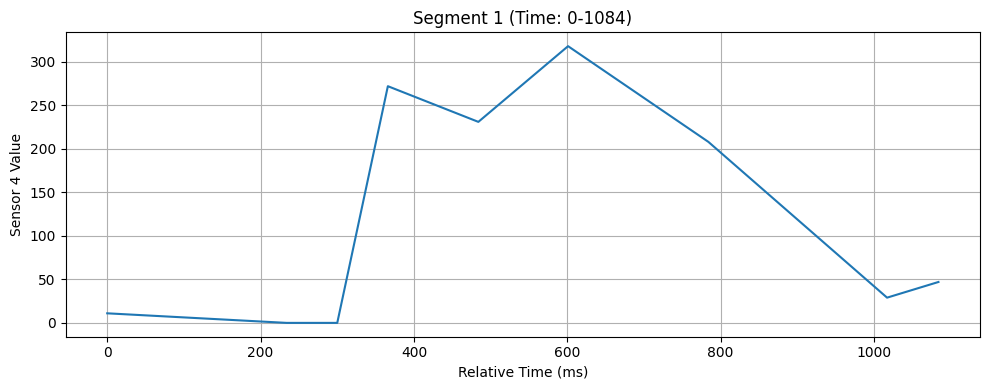

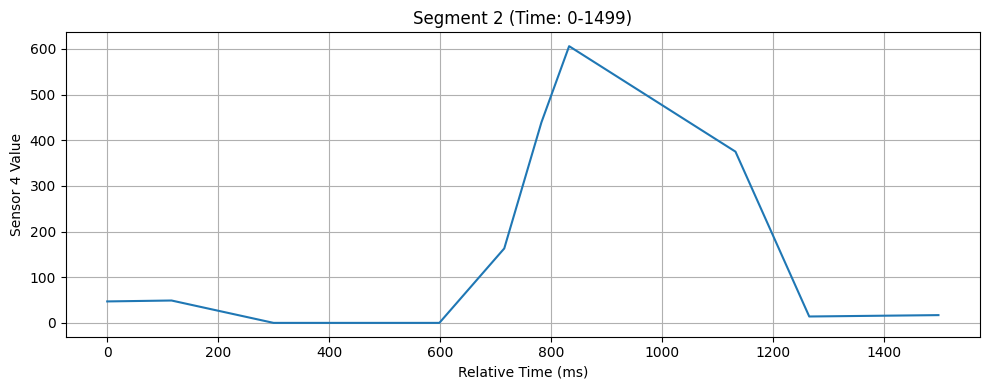

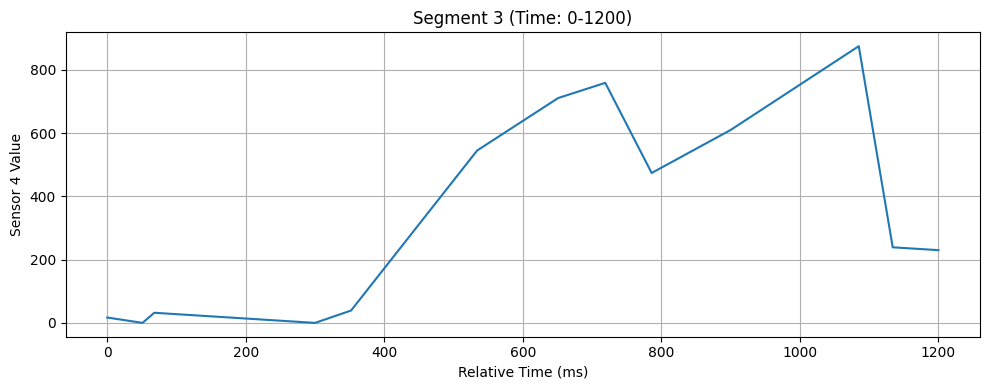

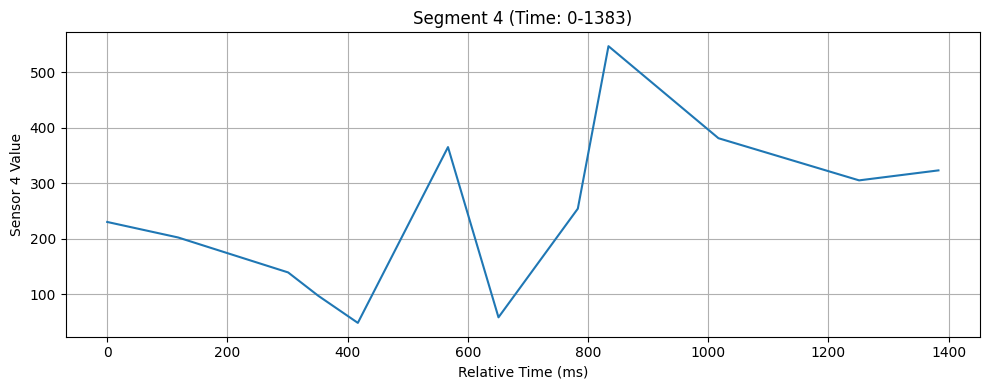

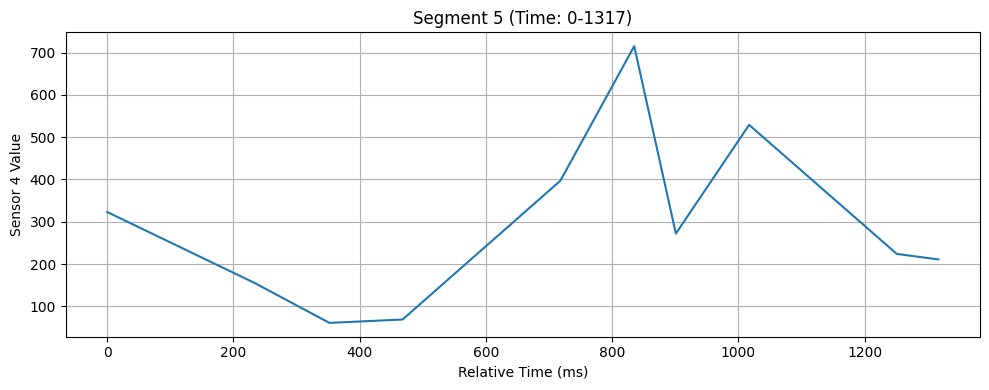

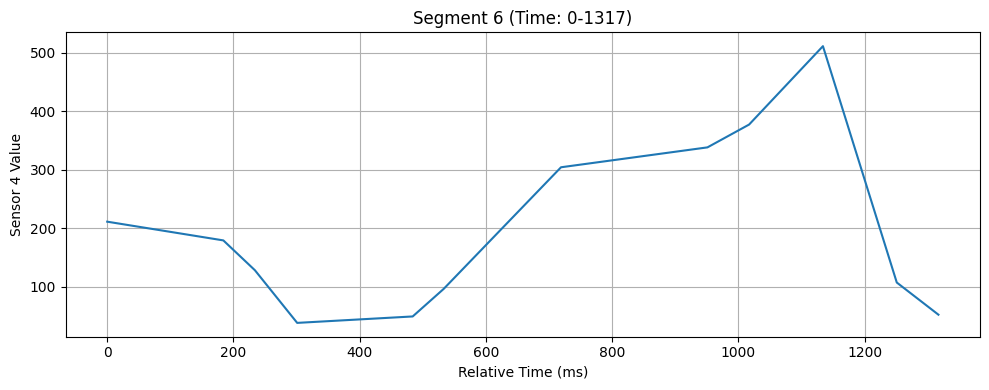

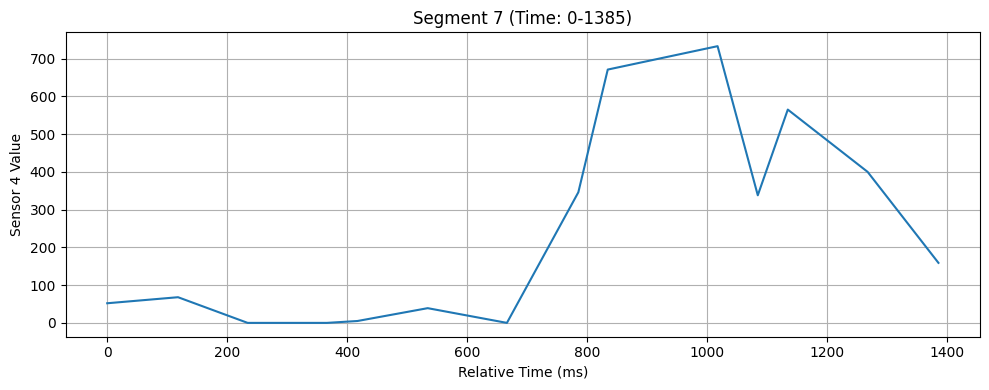

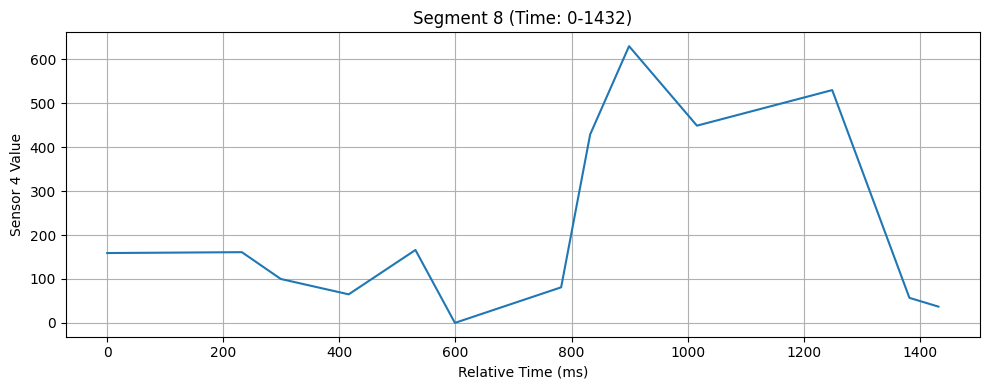

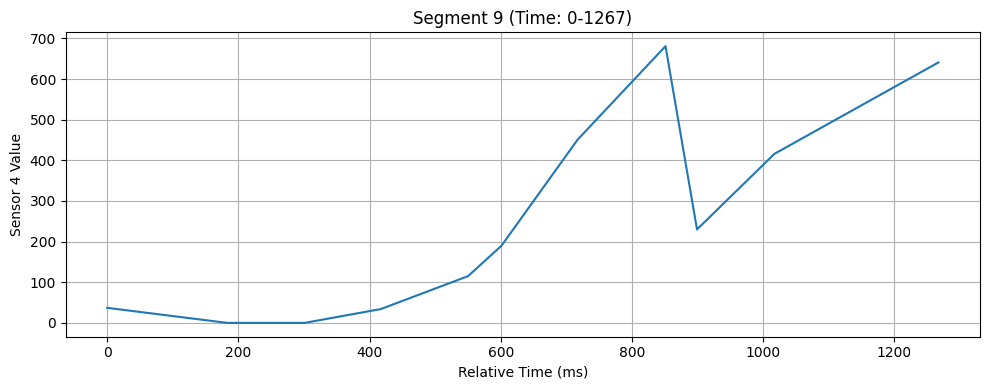

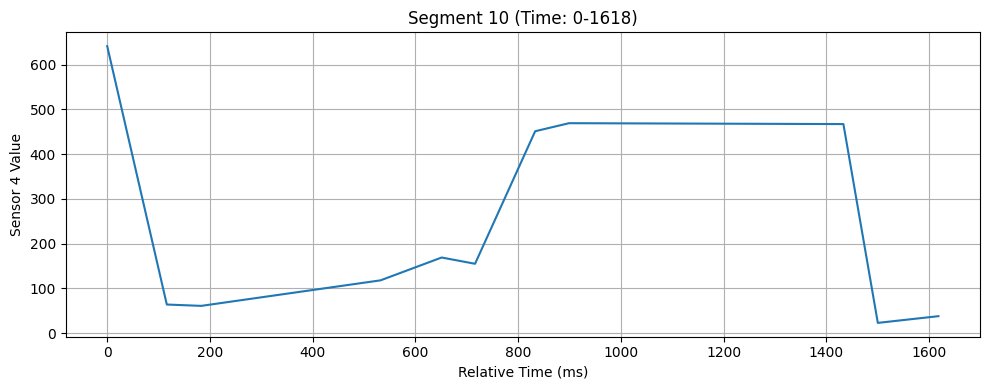

In [12]:
for i, segment_data in enumerate(segments_sensor_4[:10]):
    # Unpack only 4 values as currently available in the segment tuple
    segment_time, segment_value = segment_data

    fig, axes = plt.subplots(figsize=(10, 4)) # Create a single subplot for now

    # Plot segment_value
    axes.plot(segment_time, segment_value)
    axes.set_ylabel('Sensor 4 Value')
    axes.set_title(f'Segment {i+1} (Time: {segment_time[0]}-{segment_time[-1]})')
    axes.set_xlabel('Relative Time (ms)') # Add xlabel to the single subplot
    axes.grid(True)

    plt.tight_layout()
    plt.show()

In [28]:
segments_sensor_3[0]

([0, 234, 300, 366, 484, 601, 784, 1017, 1084],
 [0, 0, 0, 0, 0, 0, 0, 273, 230])

We will try to visualize first step

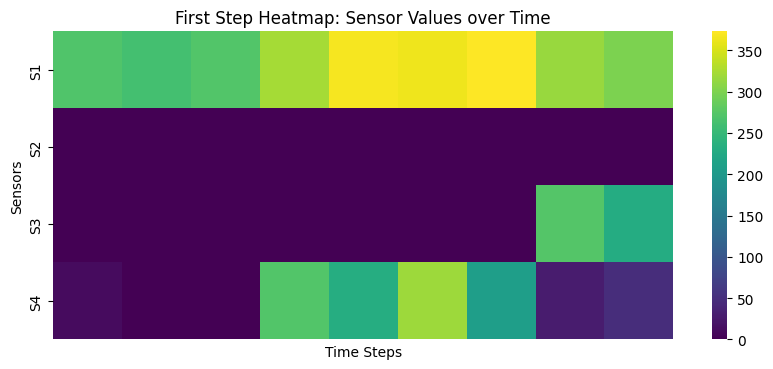

In [32]:
time_first = segments_sensor_1[0][0]
sensors_first_step = np.array([segments_sensor_1[0][1], segments_sensor_2[0][1], segments_sensor_3[0][1], segments_sensor_4[0][1]])

plt.figure(figsize=(10, 4))
sns.heatmap(sensors_first_step, cmap='viridis', xticklabels=False, yticklabels=['S1', 'S2', 'S3', 'S4'])
plt.xlabel("Time Steps")
plt.ylabel("Sensors")
plt.title("First Step Heatmap: Sensor Values over Time")
plt.show()

In [34]:
len(segments_sensor_1[1][0])

12

Second Step

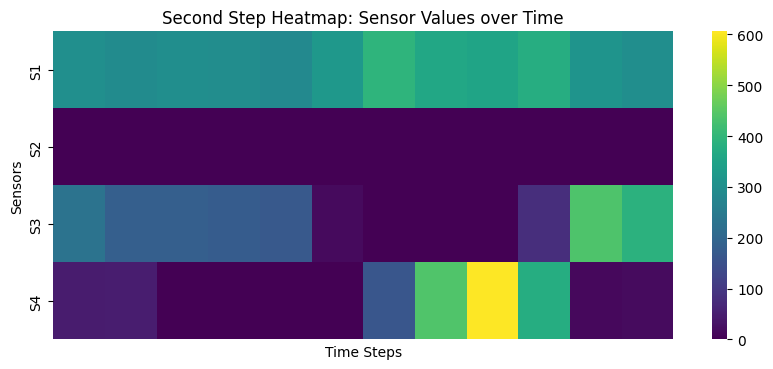

In [33]:
time_second = segments_sensor_1[1][0]
sensors_second_step = np.array([segments_sensor_1[1][1], segments_sensor_2[1][1], segments_sensor_3[1][1], segments_sensor_4[1][1]])

plt.figure(figsize=(10, 4))
sns.heatmap(sensors_second_step, cmap='viridis', xticklabels=False, yticklabels=['S1', 'S2', 'S3', 'S4'])
plt.xlabel("Time Steps")
plt.ylabel("Sensors")
plt.title("Second Step Heatmap: Sensor Values over Time")
plt.show()